# Machine Learning: Prediciendo AirBnB

## Julio Antonio Fresneda García

En este ejercicio simulado se van a obtener ciertos datos, y usarlos para poner a prueba varios algoritmos de aprendizaje supervisado de clasificación.

Los datos provienen de la web InsideAirBnB, dedicada al estudio de los alquileres vacacionales ofrecidos en la plataforma AirBnB. Este fichero es una versión editada, del listado original de información sobre las ofertas existentes, para la ciudad de Madrid, en abril de 2017.

La tarea de clasificación consistirá en clasificar los datos según el tipo de alojamiento, definido en
el campo room_type, a partir del resto de características.

Para completar este objetivo, vamos a seguir el estándar, y seguir los pasos que comunmente se usan para un proyecto de aprendizaje automático:

![procesoAA](Proceso_de_AA.svg)



# Visión general y enmarcar el problema

Los objetivos son, a partir de ciertos datos, poner a prueba ciertos algoritmos enfocados al aprendizaje supervisado. Estos algoritmos serán:
- Naive Bayes
- K-Nearest-Neighbors (KNN)
- Árboles de decisión

Dentro de "poner a prueba", se incluye la selección óptima de hiperparámetros, así como el modelado de datos (encoding, features que no usaremos, etc.). 

# Recolección de datos

Como se ha mencionado anteriormente, los datos provienen de la web InsideAirBnB, dedicada al estudio de los alquileres vacacionales ofrecidos en la plataforma AirBnB. Este fichero es una versión editada, del listado original de información sobre las ofertas existentes, para la ciudad de Madrid, en abril de 2017.

Estos datos son públicos y accesibles para cualquiera.

En esta tarea, los datos ya han sido recolectados en un csv, y están listos para ser cargados en nuestro notebook sin mayor problema.

In [1]:
import pandas as pd
airbnb = pd.read_csv("./airbnb.csv")

Vamos a echar un vistazo rápido a qué tenemos, y ver que se han cargado correctamente.

In [2]:
airbnb.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Centro,Justicia,40.424715,-3.698638,Entire home/apt,49,28,35,0.42,1,99
1,Centro,Embajadores,40.413418,-3.706838,Entire home/apt,80,5,18,0.30,1,188
2,Moncloa - Aravaca,Argüelles,40.424920,-3.713446,Entire home/apt,40,2,21,0.25,9,195
3,Moncloa - Aravaca,Casa de Campo,40.431027,-3.724586,Entire home/apt,55,2,3,0.13,9,334
4,Latina,Cármenes,40.403410,-3.740842,Private room,16,2,23,0.76,2,250


In [3]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13321 entries, 0 to 13320
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             13321 non-null  object 
 1   neighbourhood                   13321 non-null  object 
 2   latitude                        13321 non-null  float64
 3   longitude                       13321 non-null  float64
 4   room_type                       13321 non-null  object 
 5   price                           13321 non-null  int64  
 6   minimum_nights                  13321 non-null  int64  
 7   number_of_reviews               13321 non-null  int64  
 8   reviews_per_month               13321 non-null  float64
 9   calculated_host_listings_count  13321 non-null  int64  
 10  availability_365                13321 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.1+ MB


Como vemos, hay 13321 entradas, de las cuales ninguna tiene ningún campo como nulo. Esto será una ventaja a la hora de entrenar nuestros modelos.

# Preparación y análisis de los datos

## Sets de entrenamiento y test

En este apartado vamos a intentar entender un poco a qué datos nos enfrentamos.
Dado que este es un problema de clasificación, la primera pregunta que surge es, ¿cuántas clases hay?

In [4]:
airbnb.room_type.value_counts()

Entire home/apt    7926
Private room       5203
Shared room         192
Name: room_type, dtype: int64

Vemos que hay tres clases: Casa/apartamento completo, habitación privada, y habitación compartida. Vemos además, que tenemos un problema con esta última clase: Tenemos muy pocas entradas. 

La anterior observación ha sido la primera y última que vamos a hacer antes de dividir el dataset en sets de entrenamiento y test (el cual no analizaremos nunca). Esto es para evitar lo que se conoce como data snooping. 
Sin embargo, personalmente he visto conveniente, al menos, analizar el número de entradas por clase antes de dividir. Ésto es porque, si existiese una clase con muy poca representación (como es el caso), existe la remota posibilidad de dejarla completamente fuera del set de entrenamiento, lo cual nos llevaría a que nuestros modelos ni si quiera conozcan una de las tres clases.

Para elminar esa (muy remota) posibilidad de que nuestro set de entrenamiento no sea representativo del total, vamos a usar la clase **StratifiedSuffleSplit**. 
Como bien dice su nombre, esta clase mezcla las entradas de un dataset, y devuelve dos subconjuntos con una proporción por clase similar a la proporción original (estratificada).

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

# Definimos la función
def stratified_split(dataset, label_column_name, random_seed = 0, test_perc = 0.2):
    
    # Primero se divide el dataset entre features y labels, en base a un nombre de columna dado
    X, y = dataset.drop(label_column_name, axis=1), dataset[label_column_name].copy()
    
    # Creamos un objeto tipo StratifiedShuffleSplit, el cual baraja el dataset y hace 1 split, dado un porcentaje de tamaño
    splitter = StratifiedShuffleSplit(n_splits = 1, random_state = random_seed, test_size = test_perc)
    
    # Dividimos entre train y test, y devolvemos los cuatro conjuntos
    for train, test in splitter.split(X, y):     
        
        X_train = X.iloc[train]
        y_train = y.iloc[train]

        X_test = X.iloc[test]
        y_test = y.iloc[test]
        
        return X_train, y_train, X_test, y_test
    
    


Vamos a cargar nuestros sets de entrenamiento y tests. En esta tarea, el test será un 20% del dataset original.

In [6]:
X_train, y_train, X_test, y_test = stratified_split(airbnb, "room_type")


## Análisis y exploración de datos

Una vez tenemos nuestro set de entrenamiento, podemos investigar un poco para saber más sobre a qué nos podemos enfrentar. Ya que para explorar los datos vamos a hacer algunos cambios en el set, vamos a crear un set de entrenamiento.

In [7]:
exploration_set = X_train.copy()
exploration_set["room_type"] = y_train.copy()
exploration_set.head()

,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type
3502,Centro,Embajadores,40.407772,-3.701990,80,1,29,1.56,2,341,Entire home/apt
11532,Chamberí,Trafalgar,40.430156,-3.705259,48,2,3,3.00,1,278,Entire home/apt
2176,Centro,Universidad,40.424124,-3.701299,85,2,3,0.14,1,0,Entire home/apt
1851,Centro,Palacio,40.410513,-3.711581,60,5,53,1.59,1,243,Entire home/apt
12513,Arganzuela,Delicias,40.394363,-3.693493,50,2,0,0.00,2,257,Entire home/apt


Vemos que tenemos dos atributos categóricos: vecindario y grupo de vecindarios, los cuales podemos pensar que tienen relación. Tenemos además ocho atributos contínuos, de los cuales dos (longitud y latitud) representan información a priori muy relacionada a vecindario. Esto está bien saberlo por si en un futuro nos conviene prescindir de información redundante.

Vamos a ver algo de información estadística.

In [8]:
exploration_set.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,10656.000000,10656.000000,10656.000000,10656.000000,10656.000000,10656.000000,10656.000000,10656.000000
mean,40.420722,-3.697263,69.208615,2.939752,22.952797,1.518758,7.547954,205.815503
std,0.020358,0.023773,109.425210,8.412184,38.579463,1.853933,19.564387,126.810081
min,40.331888,-3.863907,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,40.410080,-3.707884,31.000000,1.000000,1.000000,0.110000,1.000000,83.750000
50%,40.418783,-3.701585,52.000000,2.000000,7.000000,0.790000,2.000000,247.000000
75%,40.427994,-3.693721,80.000000,3.000000,27.000000,2.300000,4.000000,321.000000
max,40.562736,-3.526821,7700.000000,365.000000,446.000000,17.210000,145.000000,365.000000


* La latitud y longitud son atributos con mucha precisión en sus decimales. Esto habrá que tenerlo en cuenta porque si se redondea podemos perder mucha información. 
* El precio tiene un rango muy amplio, parece que hay outliers. La desviación es notable y el máximo difiere por mucho de la media. Si escalamos, dependiendo de la técnica para escalar, estos outliers pueden influir en la escala de forma que se distorsione la información representada.
* El resto de atributos son contínuos y parece que se mueven en rangos acotados

Creo que la información se ve mucho mejor en gráficas que en texto, por tanto vamos a dibujar algunas, para ver qué encontramos interesante.

In [9]:
# Función para obtener listas con los atributos numéricos y categóricos
import numpy as np
def num_and_cat_features(X):
    numeric_features = X.select_dtypes([np.number]).columns
    categorical_features = X.select_dtypes([object]).columns
    return numeric_features, categorical_features

In [10]:
numeric_features, categorical_features = num_and_cat_features(exploration_set)
exploration_set[categorical_features] = exploration_set[categorical_features].astype('category')

Los dataframe de Python tienen una función que nos devuelve histogramas de cada atributo. Como vemos abajo, algunos atributos tienen unos pocos valores muy altos. Habrá que tener cuidado a la hora de escalar.

array([[<AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'price'}>],
       [<AxesSubplot:title={'center':'minimum_nights'}>,
        <AxesSubplot:title={'center':'number_of_reviews'}>,
        <AxesSubplot:title={'center':'reviews_per_month'}>],
       [<AxesSubplot:title={'center':'calculated_host_listings_count'}>,
        <AxesSubplot:title={'center':'availability_365'}>,
        <AxesSubplot:>]], dtype=object)

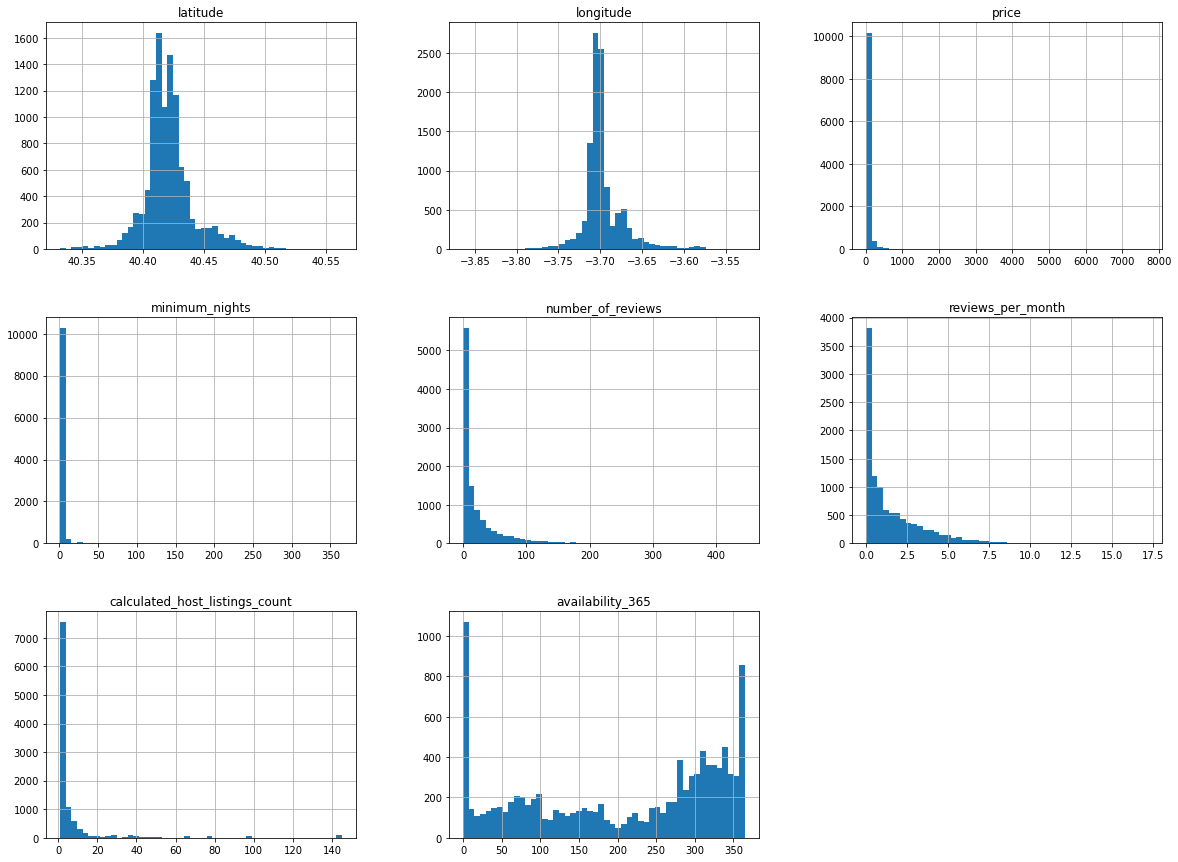

In [11]:
exploration_set.hist(bins=50, figsize=(20,15))

Vamos a dibujar en función de la longitud y latitud, coloreando según el barrio en la primera imagen, y según el tipo de habitación en la segunda. El nivel de disponibilidad lo mediremos con el radio del cada punto.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

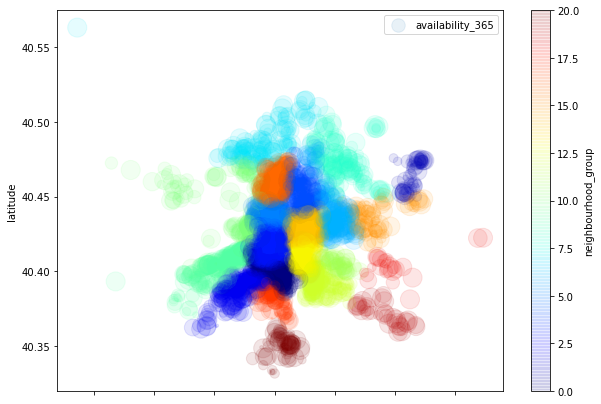

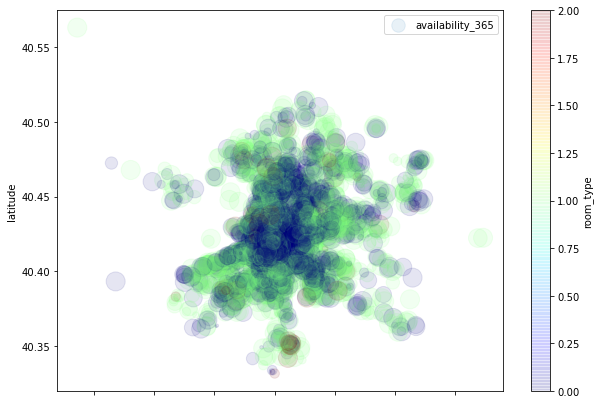

In [12]:
room_cats = exploration_set["room_type"].cat

import matplotlib.pyplot as plt
exploration_set["neighbourhood_group"] = exploration_set["neighbourhood_group"].cat.codes
exploration_set["neighbourhood"] = exploration_set["neighbourhood"].cat.codes
exploration_set["room_type"] = exploration_set["room_type"].cat.codes
exploration_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, s=exploration_set["availability_365"], label="availability_365", figsize=(10,7), c="neighbourhood_group", cmap=plt.get_cmap("jet"), colorbar=True)
exploration_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, s=exploration_set["availability_365"], label="availability_365", figsize=(10,7), c="room_type", cmap=plt.get_cmap("jet"), colorbar=True)



Los datos nos cuadran: Vemos que los puntos forman una forma que en cierta medida se parece a la ciudad de Madrid. 
En el primer gráfico se distinguen claramente los barrios, por lo que no parece que haya mucho ruido en los datos. En el segundo gráfico quizás podríamos preveer que por el centro hay acumulación de alquiler de pisos completos (azul, valor 0), mientras que por el exterior se busca más alquiler habitacional. Puede tener sentido, pues el centro es más turístico.

Vamos a ver algo más de datos con una matriz de dispersión de algunos atributos interesantes.

'Matriz de dispersion'

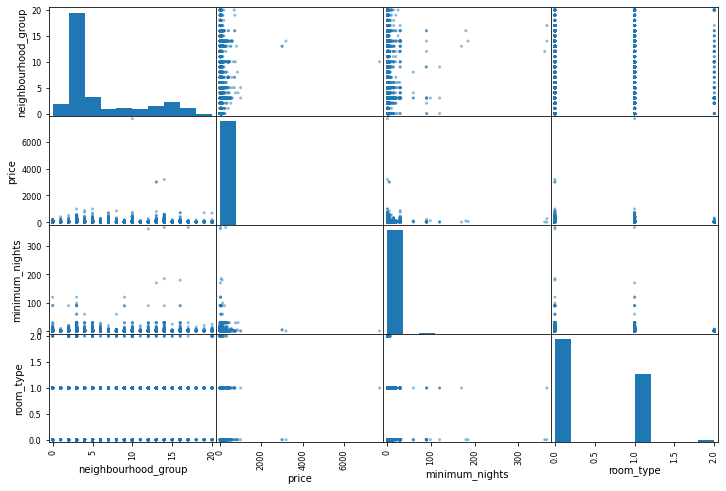

In [13]:
from pandas.plotting import scatter_matrix
attributes = ["neighbourhood_group", "price", "minimum_nights", "room_type"]
scatter_matrix(exploration_set[attributes], figsize=(12, 8))
"Matriz de dispersion"

Quizás podemos intuir algunas correlaciones interesantes:
- El precio de habitación compartida (representada con un 2 en room_type) es significativamente más barato que las otras dos clases, las cuales parece que están igual de precio salvo excepciones
- Al igual que con el precio, parece que en habitaciones compartidas piden menos noches como mínimo para la estancia
- Vemos algo de varianza en el precio según el grupo de barrios al que pertenece la estancia. Parece que hay zonas más caras que otras. Ídem con el número de noches que piden
- El precio es significativamente bajo en estancias donde no piden un mínimo de noches

Estas conclusiones pueden ser algo precipitadas y puede ser casualidad, pero no está de más fijarse.

## Preprocesamiento de datos

Este es un apartado clave de este ejercicio, y personalmente creo que es el más importante. En mi opinión, es muy fácil lanzar un algoritmo en python, la dificultad radica en cómo preprocesar los datos con lo que lo alimentamos.

Antes de nada, vamos a repasar algunas características del dataset que vamos a usar como entrenamiento:
- Está muy desbalanceada, apenas tenemos unas 150 entradas de la clase 2, de un total de más de 10 mil.
- Tenemos atributos numéricos, con unas escalas muy dispares y algunos casos de outliers.
- Tenemos dos atributos categóricos, por lo que habrá que usar algún tipo de enconding.

Teniendo en cuenta que vamos a usar el mismo set de entrenamiento ya procesado para todos los algoritmos, debemos procesarlo de forma que se adapte correctamente a las necesidades de todos ellos, en la medida de lo posible.

### Balanceado
En nuestro set de entrenamiento, claramente una de las clases está desbalanceada. Es por ello que no es mala idea corregir un poco este desequilibrio, a riesgo de que la clase no tenga suficiente peso para que el modelo pueda aprender correctamente de ella. Si bien es cierto que para árboles de decisión ésto se puede corregir desde sus parámetros, para Naive Bayes y KNN debemos usar otras técnicas.

Por ello usaremos una función genérica que balancee datasets desbalanceados, duplicando las entradas menos comunes (oversampling).

In [14]:
from imblearn import over_sampling

# Funcion de oversampling
def oversample(X, y, y_name, to_clone, ratio):
    dfX = X.copy()
    dfX[y_name] = y
    
    df = dfX[dfX[y_name] == to_clone]
    for i in range(ratio):
        dfX = pd.concat([dfX,df])
    
    
    
    return dfX.drop(y_name, axis=1), dfX[y_name].copy()
    

In [15]:
# Balanceamos un poco, multiplicando por 10
X_train, y_train = oversample(X_train, y_train, 'room_type', 'Shared room', 10)

In [16]:
y_train.value_counts()

Entire home/apt    6340
Private room       4162
Shared room        1694
Name: room_type, dtype: int64

### Escalado

sklearn nos da un abanico de métodos de escalado, cada uno con distintas propiedades. Antes de elegir uno, vamos a listarlos con una breve descripción:
- MinMaxScaler: Escala cada atributo dado un rango concreto
- MaxAbsScaler: Escala cada atributo entre 0 y 1, en base a su máximo absoluto
- StandardScaler: Sigue la distribución normal estándar (SND). Por lo tanto, hace media = 0 y escala los datos a la varianza unitaria.
- RobustScaler: Elimina la mediana y escala de acuerdo con el rango de cuantiles (el valor predeterminado el rango entre el primer cuartil (cuantil 25) y el tercer cuartil (cuantil 75).

Tanto MinMaxScaler como MaxAbsScaler son muy sensibles a outliers. Por ejemplo, con rango 0-1, si tenemos un atributo cuyos valores van entre 0 y 1, excepto un outlier con un valor de 100, el escalado los transformará en valores entre 0 y 0.01, excepto 1 para el outlier. Claramente esto puede confundir al algoritmo. 
Dado que tenemos varios outliers en nuestros datos, como hemos visto antes, quizás deberíamos elegir otra alternativa.

Quizás en otros problemas podríamos eliminar los outliers asumiendo que son ruido y usar cualquier tipo de escalado, pero aquí los outliers quizás sí aportan información relevante al modelo. Por tanto, vamos a usar RobustScaler().

Hay que tener en cuenta que hay algoritmos como Multinomial Naive Bayes o Compliment Naive Bayes no aceptan valores negativos, por tanto StandardScaler y RobustScaler nos puede dar problemas si centramos en el 0. Teniendo en cuenta que son algoritmos enfocados a problemas sobre textos y conteo de palabras, quizás nos convendría descartarlos, pero en vez de eso, vamos a probar a re-escalar con MinMax al final, sólo para estos algoritmos. 

Vamos a crear un primer Pipeline (que encadenaremos con otros) con el escalado elegido. Además añado como buena práctica, un transformador que rellena los datos null con la media. Digo como buena práctica porque en este caso no hay datos nulos.
También creamos otro pipeline específico para los casos antes mencionados.

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
PIPE_robust_scaler = Pipeline([('imputer', SimpleImputer(strategy="median")), ('robust_scaler', RobustScaler())])
PIPE_robust_and_minmax_scaler = Pipeline([('imputer', SimpleImputer(strategy="median")), ('robust_scaler', RobustScaler()), ('minmax_scaler', MinMaxScaler())])

### Encoding

Igual que con el escalado, existen diversas técnicas de encoding. Las que más he visto usar son OrdinalEncoding y OneHotEncoding. Ninguna me termina de convencer:
- OrdinalEncoding: Asocia un ordinal a cada valor único del atributo. Tiene como problema que algunos algoritmos asumen que dos valores cercanos tienen más en común que dos valores lejanos: El barrio 2 estará más relacionado con el barrio 3 que con el 12, cuando en realidad no es así.
- OneHotEncoding: Para solucionar el problema anterior, OneHotEncoding crea n columnas para cada atributo, siendo n el número de valores únicos. Pone a 1 la columna del valor en cuestión, y 0 el resto. Como problema, se crean demasiados atributos nuevos. Esto, puede lastrar el desempeño de los algoritmos teniendo un dataset pequeño (10k).

Una posible codificación podría ser la Binary Encoding. Es prácticamente igual que OneHotEncoding, excepto que usa notación binaria. Esto reduce drásticamente el número de columnas necesarias.

Por tanto, BinaryEncoding va a ser nuestra selección.

In [18]:
from category_encoders import BinaryEncoder
PIPE_encode_binary = Pipeline([('encoder', BinaryEncoder())])

#### Pipeline final, y preprocesamiento de datos

Crearemos un pipeline final que aplique el escalado a los atributos numéricos y la codificación a los atributos categóricos, los cuales no escalaremos pues sus valores son 1 o 0.
Ídem con su alternativa con MinMax.

In [19]:
from sklearn.compose import ColumnTransformer
numeric_features, categorical_features = num_and_cat_features(X_train)
PIPELINE = ColumnTransformer([("numeric_features", PIPE_robust_scaler, numeric_features), ("categorical_features", PIPE_encode_binary, categorical_features)])
PIPELINE_w_MinMax = ColumnTransformer([("numeric_features", PIPE_robust_and_minmax_scaler, numeric_features), ("categorical_features", PIPE_encode_binary, categorical_features)])

In [20]:
# Preprocesamos nuestros datos
X_train_piped = PIPELINE.fit_transform(X_train)
X_test_piped = PIPELINE.fit_transform(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## Elegir algoritmo

Ya tenemos nuestros datos preprocesados, es hora de probar algoritmos. Pero antes de eso, vamos a declarar algunas funciones que nos serás útiles para visualizar qué tal funciona nuestro modelo.

In [21]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay

# Realiza la validacion cruzada, y pinta los resultados
def cross_val_score_and_print(X, y, model):

        
        
    scores = cross_val_score(model, X, y, cv=10)
    
    
    
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
# Pinta la matriz de confusion
def evaluate_model(X, y, model):
    y_pred = model.predict(X)

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.show()
     
    # Accuracy
    print("Accuracy:")
    print(accuracy_score(y, y_pred))
    
    # Recall
    print("Recall:")
    print(recall_score(y, y_pred, average=None))
    
    # Precision
    print("Precision:")
    print(precision_score(y, y_pred, average=None))
    
    # F1 Score
    print("F1 Score:")
    print(f1_score(y, y_pred, average=None))
    
    

Para elegir un modelo, necesitamos saber qué algoritmo es más probable que funcione en nuestro problema. Para ello, usaremos validación cruzada.

En la validación cruzada, se divide el set de entrenamiento en n partes, y se entrena el algoritmo n veces con n-1 partes, probándose contra la parte restante.

Una vez tengamos medias de todos los algoritmos, elegiremos el mejor y lo entrenaremos con todo el set de entrenamiento, validandolo conta el test original.

### Naive Bayes

Los métodos de Naive Bayes son un conjunto de algoritmos de aprendizaje supervisados basados en la aplicación del teorema de Bayes con el supuesto "ingenuo" de independencia condicional entre cada par de características dado el valor de la variable de clase.

Hay diversas versiones, cada una con sus ventajas y desventajas. En principio, no aceptan ningún tipo de parámetro relacionado con el balanceo.

#### Gaussian Naive Bayes
Supone que la probabilidad de las características sigue una distribución gaussiana.

Vamos a entrenar el modelo. Los datos ya están preprocesados, sólo falta lanzarlo. P

In [22]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()


Hacemos validación cruzada

In [23]:
cross_val_score_and_print(X_train_piped, y_train, model)

Scores: [0.47213115 0.48852459 0.47213115 0.47622951 0.46721311 0.4942623
 0.48236259 0.47908121 0.47744053 0.47579984]
Mean: 0.47851759706289754
Standard deviation: 0.007656915402261855


Una media de 0.47 de acierto, menos acierto que jugar a cara o cruz. Parece que Gaussian Naive Bayes no funciona demasiado bien.

#### Multinomial Naive Bayes

Implementa el NB para datos distribuidos de forma multinomial. Funciona especialmente bien con problemas de textos, pero quizás en este caso nos sorprenda. Como requisito, no admite valores negativos, por lo que usaremos la versión MinMax del pipeline.

In [24]:
X_train_piped_w_minmax = PIPELINE_w_MinMax.fit_transform(X_train)

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [25]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
cross_val_score_and_print(X_train_piped_w_minmax, y_train, model)

Scores: [0.56393443 0.56065574 0.56147541 0.56885246 0.54754098 0.56639344
 0.55455291 0.57506153 0.57178015 0.55209188]
Mean: 0.5622338923331406
Standard deviation: 0.008369489853702509


Una media de 0.56 de acierto. Algo mejor que el gaussiano.

#### Complement Naive Bayes

El CNB es una adaptación del Multinomial, funciona especialmente bien con datasets poco balanceados. Nuestro set sigue sin estar del todo balanceado, quizás mejore algo la media.

In [26]:
from sklearn.naive_bayes import ComplementNB
model = ComplementNB()
cross_val_score_and_print(X_train_piped_w_minmax, y_train, model)

Scores: [0.51885246 0.54508197 0.54918033 0.53852459 0.51803279 0.55901639
 0.53896637 0.53814602 0.5414274  0.53158326]
Mean: 0.5378811576271871
Standard deviation: 0.011984036925327209


Media de 0.53. Parece que no ha funcionado como esperábamos.

### K-Nearest Neighbors

El KNN es un algoritmo simple pero potente, que clasifica en función de los K vecinos más cercanos. Una tarea importante es ajustar el hiperparámetro K. Pero primero, vamos a probar con K por defecto, a ver cómo se comporta.
    

In [27]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
cross_val_score_and_print(X_train_piped, y_train, model)

Scores: [0.83114754 0.82868852 0.83032787 0.83770492 0.82213115 0.8295082
 0.84987695 0.85069729 0.83511075 0.86054143]
Mean: 0.8375734611815652
Standard deviation: 0.011547584892807808


Una media de 0.83. Bastante mejor que los Naive Bayes, parece ser, y aún no hemos ajustado K. Vamos a ajustarla, teniendo en cuenta que lo ideal es que sea impar, y no sea múltiplo del número de clases, para evitar fronteras.

Para estimar los hiperparámetros ideales, podemos usar la clase GridSearchCV

In [28]:
from sklearn.model_selection import GridSearchCV
nn = []
for i in range(1,100):
    if(i%2 != 0 and i%3 != 0):
        nn.append(i)

grid_params = {'n_neighbors':nn}
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv = 10, n_jobs = -1)
gs_results = gs.fit(X_train_piped, y_train)

Fitting 10 folds for each of 33 candidates, totalling 330 fits


In [29]:
print("Best score:")
print(gs_results.best_score_)
print("Best estimator:")
print(gs_results.best_estimator_)
print("Best params:")
print(gs_results.best_params_)

Best score:
0.8461798840759022
Best estimator:
KNeighborsClassifier(n_neighbors=1)
Best params:
{'n_neighbors': 1}


Parece que como mejor resultados obtenemos es con K igual a 1, es decir, estimar en función de su vecino más cercano. Tiene cierto sentido, teniendo en cuenta que hablamos de pisos y habitaciones.

GridSearchCV ya hace validación cruzada por nosotros, por lo que no tenemos que repetirla.

### Decission Trees

Por último, vamos a probar con árboles de decisiones. Aunque hemos balanceado un poco nuestro set de entrenamiento, vamos a buscar el balance también usando el hiperparámetro disponible. Al igual que antes, probamos primero con los parámetros por defecto, para ver el comportamiento.

In [30]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(class_weight='balanced')
cross_val_score_and_print(X_train_piped, y_train, model)

Scores: [0.89508197 0.88606557 0.90491803 0.88442623 0.88688525 0.87459016
 0.88843314 0.89253486 0.88515176 0.88597211]
Mean: 0.8884059091703762
Standard deviation: 0.007518537721253298


Media de 0.88! Hasta ahora, el mejor algoritmo que hemos probado. Vamos a calcular los mejores hiperparámetros disponibles.

In [31]:
max_leaf_nodes = list(range(2,51))
min_samples_split = list(range(2,7))
max_depth = list(range(1,21))


grid_params = {'max_leaf_nodes':max_leaf_nodes, 'min_samples_split':min_samples_split, 'max_depth':max_depth, 'class_weight':["balanced"]}
gs = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), grid_params, verbose = 1, cv = 10, n_jobs = -1)
gs_results = gs.fit(X_train_piped, y_train)

Fitting 10 folds for each of 4900 candidates, totalling 49000 fits


In [32]:
print("Best score:")
print(gs_results.best_score_)
print("Best estimator:")
print(gs_results.best_estimator_)
print("Best params:")
print(gs_results.best_params_)

Best score:
0.8379003886550385
Best estimator:
DecisionTreeClassifier(class_weight='balanced', max_depth=8, max_leaf_nodes=50)
Best params:
{'class_weight': 'balanced', 'max_depth': 8, 'max_leaf_nodes': 50, 'min_samples_split': 2}


Un 83% de acierto. Sin duda, parece un modelo prometedor. Puede sorprender que con los valores por defecto se obtenga más puntuación (88), pero probablemente sea causa de overfitting. Si nos fijamos en los parámetros usados con GridSearch, uno limita el número de hojas y otro la profundidad. Es muy probable que ésto nos evite el overfitting, y contraintuitivamente lo haga funcionar mejor en el mundo real.

## Entrenar con el algoritmo elegido

Parece que, por poco, el KNN ha resultado ser el mejor algoritmo, o al menos, el que mejor resultados ha dado en el set de entrenamiento. Vamos a entrenarlo con todo el set, para probarlo en nuestro set de test original, el cual no hemos mirado en absoluto para evitar data snooping. Quizás haya mala suerte y no funcione como se espera, vamos a averiguarlo. Usamos el hiperparametro de k=1.

In [33]:
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train_piped, y_train)

KNeighborsClassifier(n_neighbors=1)

Ya tenemos el modelo entrenado, vamos a evaluarlo con el set de test

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


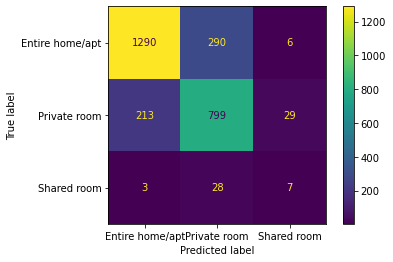

Accuracy:
0.7864915572232646
Recall:
[0.81336696 0.76753122 0.18421053]
Precision:
[0.85657371 0.71530886 0.16666667]
F1 Score:
[0.83441138 0.74050046 0.175     ]


In [34]:
X_test_piped = PIPELINE.fit_transform(X_test)
evaluate_model(X_test_piped, y_test, model)

Una precisión de casi un 80%! No está nada mal. En la matriz de confusión podemos obtener más información. Vemos que clasifica estupendamente los apartamentos completos, ha habido pocos casos donde los ha confundido con habitaciones. Ídem para habitaciones unipersonales. Con habitaciones compartidas en cambio, el modelo no es demasiado bueno. Si bien no los confunde prácticamente con pisos completos (solo faltaría!), casi todas las interpreta como habitaciones unipersonales.

En cuanto al recall, precision y F1, todas van en la misma linea y ninguna destaca de sobremanera.

En general es un modelo equilibrado en el sentido de que hay numeros parecidos entre falsos positivos y falsos negativos.

## Conclusiones finales

Respecto al problema, está claro que la parte difícil es clasificar las habitaciones compartidas. Era de esperar, estaba muy desbalanceada en ese caso, y quizás al ser casos poco comunes, sus características no siguen un patrón tan fácil de encontrar como con habitaciones o pisos.

Respecto a los algoritmos, creo que cuadra lo que hemos visto con el funcionamiento de cada algoritmo. 
* Naive Bayes asume independencia entre cada una de los atributos, es decir, ninguno influye sobre otro. Esto es difícil que sea así, por ejemplo, hay barrios mucho más caros que otros, y a mayor precio se espera que haya menos valoraciones, pues menos gente puede permitírselo.
* Los árboles de decisión quizás sí hubieran funcionado mejor con habitaciones compartidas, por su modelo de funcionamiento. Pero tienden al overfitting, por tanto una puntuación alta puede engañar, incluso con cross validation.
* KNN en mi opinión es el algoritmo con más sentido, en este problema en particular, y así lo han demostrado las puntuaciones. Digo esto porque es muy raro que una habitación o piso de alquiler tenga un precio muy dispar con la competencia de la zona. Sí que se pueden dar casos por ejemplo en los que estén en la frontera con otro barrio más rico, o haya alguna excepción, pero por lo general suele estar bastante equilibrado en la vida real. La parte negativa del KNN, es que es muy dificil que prediga bien excepciones: Puede haber un piso muy caro porque el edificio sea de renombre, por ejemplo, en un barrio normal, con pisos vecions a un precio normal. Esto KNN no lo puede controlar.

## Bibliografia

* Medidas: https://towardsdatascience.com/how-to-evaluate-your-machine-learning-models-with-python-code-5f8d2d8d945b
* Naive Bayes: https://scikit-learn.org/stable/modules/naive_bayes.html
* KNN: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
* Decision trees: https://scikit-learn.org/stable/modules/tree.html
* Distintos tipos de encoding: https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/
* Clase para balancear (No se ha acabado usando, pero es interesante): https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/